<a href="https://colab.research.google.com/github/kkokay07/GenomicClass_on_Cloud/blob/master/NGS_Variant_calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creator: Dr. KANAKA K. K.
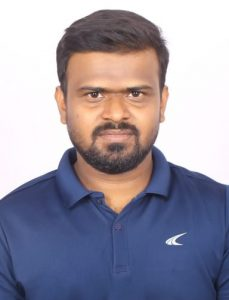

PhD, ARS  
Scientist

School of Bioinformatics

ICAR-Indian Institute of Agricultural Biotechnology, Ranchi, Jharkhand.

Spy on me at :)  
[Google Scholar](https://scholar.google.com/citations?hl=en&user=0dQ7Sf8AAAAJ&view_op=list_works);    [ResearchGate](https://www.researchgate.net/profile/Kanaka-K-K/research);    [Website](https://iiab.icar.gov.in/staff/dr-kanaka-k-k/)

**NGS Variant Calling Tutorial**

- **Aim:** Identify genetic variants (SNPs) in E. coli samples
- **Tools:** fastp, BWA, SAMtools, BCFtools
- **Input:** Two E. coli K-12 paired-end sequencing samples (SRR10527348, SRR10527349)
- **Steps:**
  1. Quality control of raw reads
  2. Alignment to reference genome
  3. BAM file processing
  4. Variant calling and filtering
- **Environment:** Google Colab (cloud-based, no local installation needed)
- **Expected output:** VCF file containing high-quality genetic variants
- **Time:** ~2 hours (depends on data download speed)

# If you find descriptions as boring, skip the text and simply run the codes!

# i. Setup Environment
"""First, we need to install the required bioinformatics tools"""

In [2]:
# Import required libraries and setup directories
import os
from google.colab import drive
import datetime

# Mount Google Drive
drive.mount('/content/drive')

# Create directory structure
project_dir = "/content/variant_calling"
os.makedirs(project_dir, exist_ok=True)

# Create subdirectories
dirs = [
    'raw_data',
    'cleaned_data',
    'reference',
    'alignments',
    'variants',
    'reports'
]

for d in dirs:
    os.makedirs(f"{project_dir}/{d}", exist_ok=True)

print("Directory structure created successfully!")

Mounted at /content/drive
Directory structure created successfully!


# ii. Install tools

**fastp**
- Quality control tool for FASTQ files
- Removes low quality reads/bases
- Trims sequencing adapters
- Provides QC reports with statistics and graphs
- Filters out contaminated reads

**BWA (Burrows-Wheeler Aligner)**
- Aligns sequencing reads to reference genome
- Specially designed for short read alignment
- BWA-MEM algorithm handles paired-end reads
- Outputs alignments in SAM format
- Handles mismatches and gaps in sequences

**SAMtools**
- Manipulates SAM/BAM format files
- Converts SAM to BAM (binary format)
- Sorts and indexes BAM files
- Generates alignment statistics
- Extracts specific regions from alignments
- Views and filters aligned reads

**BCFtools**
- Variant calling from BAM files
- Creates and manipulates VCF files
- Filters variants based on quality scores
- Performs variant genotyping
- Handles multi-sample variant calling
- Allows annotation of variants

In [3]:
# Install required tools
!apt-get update && apt-get install -y fastp bwa samtools bcftools

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,677 kB]
Get:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:11 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [62.6 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Package

In [4]:
# Install SRA toolkit
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
!tar -xzf sratoolkit.current-ubuntu64.tar.gz
!mv sratoolkit.*/bin/* /usr/local/bin/
!rm sratoolkit.current-ubuntu64.tar.gz

--2026-02-08 04:58:44--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92046842 (88M) [application/x-gzip]
Saving to: ‘sratoolkit.current-ubuntu64.tar.gz’

sratoolkit.current- 100%[===================>]  87.78M   130MB/s    in 0.7s    

2026-02-08 04:58:45 (130 MB/s) - ‘sratoolkit.current-ubuntu64.tar.gz’ saved [92046842/92046842]



# iii. Understanding the Input Data: FASTQ Format

FASTQ files contain sequencing reads with quality scores. Each read has 4 lines:
1. Read identifier (starts with @)
2. Sequence
3. '+' separator
4. Quality scores (ASCII-encoded)

Example of FASTQ format:

@SRR001666.1

GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGT

'+'

!''*((((***+))%%%++)(%%%%).1***-+*''))**55CCF>>>>>>CCCCCCC65

Let's download a small test dataset (E. coli K-12): This tutorial demonstrates variant calling with two samples, each with paired-end reads.
Sample1 and Sample2
Each sample has forward (R1) and reverse (R2) reads.

# 1. Download samples

In [5]:
# Download sample 1
%cd /content/variant_calling/raw_data
print("Downloading Sample 1...")
!fastq-dump --split-files SRR10527348
print("\nSample 1 files:")
!ls -lh SRR10527348*

/content/variant_calling/raw_data
Read 2281618 spots for SRR10527348
Written 2281618 spots for SRR10527348

Sample 1 files:
-rw-r--r-- 1 root root 609M Feb  8 05:04 SRR10527348_1.fastq
-rw-r--r-- 1 root root 609M Feb  8 05:04 SRR10527348_2.fastq


In [6]:
# Download sample 2
%cd /content/variant_calling/raw_data
print("\nDownloading Sample 2...")
!fastq-dump --split-files SRR10527349
print("\nSample 2 files:")
!ls -lh SRR10527349*

/content/variant_calling/raw_data

Read 1649218 spots for SRR10527349
Written 1649218 spots for SRR10527349

Sample 2 files:
-rw-r--r-- 1 root root 440M Feb  8 05:06 SRR10527349_1.fastq
-rw-r--r-- 1 root root 440M Feb  8 05:06 SRR10527349_2.fastq


# 2. Reference Genome
**Reference Genome**

**Definition**: A digital nucleotide sequence database assembled to represent a species' genetic makeup, used as a standard for comparison in sequencing studies.

**Common Formats**:
- FASTA (.fa/.fasta)
  - Simple text format
  - Header line starts with '>' symbol
  - Contains sequence data in subsequent lines
  - Example:
    ```
    >Chr1
    ATGCTAGCTAGCTGATCG
    GCTAGCTAGCTGATCGAT
    ```

**Required Files for Alignment**:
- Main reference file (.fasta)
- Index files (created by tools)
  - BWA index (.amb, .ann, .bwt, .pac, .sa)
  - FASTA index (.fai)
  - Dictionary (.dict)

**Common Sources**:
- NCBI RefSeq
- Ensembl
- UCSC Genome Browser

**E. coli Reference Example**:
- Strain: K-12 MG1655
- Size: ~4.6 Mb
- Single circular chromosome
- Well-annotated for teaching purposes

In [7]:
# Download the reference genome
%cd /content/variant_calling/reference

print("Downloading reference genome...")
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz
!gunzip GCF_000005845.2_ASM584v2_genomic.fna.gz
!mv GCF_000005845.2_ASM584v2_genomic.fna reference.fasta

/content/variant_calling/reference
--2026-02-08 05:07:30--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1379902 (1.3M) [application/x-gzip]
Saving to: ‘GCF_000005845.2_ASM584v2_genomic.fna.gz’

GCF_000005845.2_ASM 100%[===================>]   1.32M  --.-KB/s    in 0.09s   

2026-02-08 05:07:30 (14.6 MB/s) - ‘GCF_000005845.2_ASM584v2_genomic.fna.gz’ saved [1379902/1379902]



**Why Index Reference Files**

1. **Speed & Efficiency**
   - Enables quick lookup of sequences
   - Avoids scanning entire file for each query
   - Reduces memory usage

2. **Random Access**
   - Allows direct access to specific regions
   - Skips reading entire genome
   - Essential for targeted analysis

3. **Tool Requirements**
   - BWA requires .amb, .ann, .bwt, .pac, .sa files
   - SAMtools needs .fai file
   - Most alignment tools won't work without indexes

4. **Common Analogy**
   - Like a book's table of contents
   - Helps find content quickly
   - Instead of reading every page

5. **Practical Impact**
   - Reduces runtime from hours to minutes
   - Enables processing of large datasets
   - Critical for high-throughput analysis

In [8]:
# Index reference genome
print("\nIndexing reference genome...")
!bwa index reference.fasta
!samtools faidx reference.fasta


Indexing reference genome...
[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 2.28 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.04 sec
[bwa_index] Construct SA from BWT and Occ... 1.39 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index reference.fasta
[main] Real time: 3.981 sec; CPU: 3.797 sec


# 3. Quality Control with fastp

fastp performs quality control and filtering on FASTQ files.
- Removes low-quality bases
- Trims adapters
- Generates QC reports

Input:
- Raw FASTQ files


Output:
- Cleaned FASTQ files
- HTML report with quality metrics

**FASTQ Format** (Cleaned FASTQ files)
```
@SRR10527348.1
ATGCTAGCTAGCTGATCGATGC
+
!''*((((***+))%%%++)(%%
```
- Line 1: Header (starts with @)
- Line 2: DNA sequence
- Line 3: Separator (+)
- Line 4: Quality scores (ASCII-encoded)

**HTML Report Format**
```html
Summary Section:
- Total reads: 1,000,000
- Filtered reads: 50,000
- Q30 bases: 95%

Graphs/Charts:
- Quality score distribution
- GC content plot
- Length distribution
- Adapter content

Detailed Statistics:
- Before/After filtering metrics
- Duplication rates
- Base composition
```

Key Features of HTML Report:
- Interactive visualizations
- Color-coded metrics
- Downloadable charts
- Easy to share/view in browser
- No special software needed

*Note: fastp generates comprehensive reports that help assess sequencing quality and effectiveness of cleaning steps*

In [9]:
# Check number of lines in each sample
!wc -l \
/content/variant_calling/raw_data/SRR10527348_1.fastq \
/content/variant_calling/raw_data/SRR10527348_2.fastq \
/content/variant_calling/raw_data/SRR10527349_1.fastq \
/content/variant_calling/raw_data/SRR10527349_2.fastq

   9126472 /content/variant_calling/raw_data/SRR10527348_1.fastq
   9126472 /content/variant_calling/raw_data/SRR10527348_2.fastq
   6596872 /content/variant_calling/raw_data/SRR10527349_1.fastq
   6596872 /content/variant_calling/raw_data/SRR10527349_2.fastq
  31446688 total


In [10]:
# Check number of reads. Reads = (Number of lines/4)
!awk '{printf "%s\t%d reads\n", $2, $1/4}' \
<(wc -l /content/variant_calling/raw_data/*.fastq)

/content/variant_calling/raw_data/SRR10527348_1.fastq	2281618 reads
/content/variant_calling/raw_data/SRR10527348_2.fastq	2281618 reads
/content/variant_calling/raw_data/SRR10527349_1.fastq	1649218 reads
/content/variant_calling/raw_data/SRR10527349_2.fastq	1649218 reads
total	7861672 reads


In [11]:
# Process Sample 1
print("Processing Sample 1...")
!fastp \
    -i /content/variant_calling/raw_data/SRR10527348_1.fastq \
    -I /content/variant_calling/raw_data/SRR10527348_2.fastq \
    -o /content/variant_calling/cleaned_data/SRR10527348_1.clean.fastq.gz \
    -O /content/variant_calling/cleaned_data/SRR10527348_2.clean.fastq.gz \
    --html /content/variant_calling/reports/SRR10527348_fastp.html \
    --json /content/variant_calling/reports/SRR10527348_fastp.json \
    --qualified_quality_phred 20 \
    --length_required 50

Processing Sample 1...
Read1 before filtering:
total reads: 2281618
total bases: 228128864
Q20 bases: 223900507(98.1465%)
Q30 bases: 220104460(96.4825%)

Read2 before filtering:
total reads: 2281618
total bases: 228137436
Q20 bases: 215029047(94.2542%)
Q30 bases: 206512369(90.521%)

Read1 after filtering:
total reads: 2167596
total bases: 216989871
Q20 bases: 214258426(98.7412%)
Q30 bases: 211636486(97.5329%)

Read2 aftering filtering:
total reads: 2167596
total bases: 216987041
Q20 bases: 209884678(96.7268%)
Q30 bases: 204157255(94.0873%)

Filtering result:
reads passed filter: 4335192
reads failed due to low quality: 216638
reads failed due to too many N: 158
reads failed due to too short: 11248
reads with adapter trimmed: 2012
bases trimmed due to adapters: 33402

Duplication rate: 1.21472%

Insert size peak (evaluated by paired-end reads): 166

JSON report: /content/variant_calling/reports/SRR10527348_fastp.json
HTML report: /content/variant_calling/reports/SRR10527348_fastp.html



In [12]:
# Process Sample 2
print("\nProcessing Sample 2...")
!fastp \
    -i /content/variant_calling/raw_data/SRR10527349_1.fastq \
    -I /content/variant_calling/raw_data/SRR10527349_2.fastq \
    -o /content/variant_calling/cleaned_data/SRR10527349_1.clean.fastq.gz \
    -O /content/variant_calling/cleaned_data/SRR10527349_2.clean.fastq.gz \
    --html /content/variant_calling/reports/SRR10527349_fastp.html \
    --json /content/variant_calling/reports/SRR10527349_fastp.json \
    --qualified_quality_phred 20 \
    --length_required 50


Processing Sample 2...
Read1 before filtering:
total reads: 1649218
total bases: 165347518
Q20 bases: 162232943(98.1163%)
Q30 bases: 159457249(96.4376%)

Read2 before filtering:
total reads: 1649218
total bases: 165351647
Q20 bases: 153954738(93.1075%)
Q30 bases: 146686707(88.712%)

Read1 after filtering:
total reads: 1547306
total bases: 155228895
Q20 bases: 153434087(98.8438%)
Q30 bases: 151699724(97.7265%)

Read2 aftering filtering:
total reads: 1547306
total bases: 155226992
Q20 bases: 149349122(96.2134%)
Q30 bases: 144670098(93.1991%)

Filtering result:
reads passed filter: 3094612
reads failed due to low quality: 199102
reads failed due to too many N: 100
reads failed due to too short: 4622
reads with adapter trimmed: 1036
bases trimmed due to adapters: 22308

Duplication rate: 0.989916%

Insert size peak (evaluated by paired-end reads): 167

JSON report: /content/variant_calling/reports/SRR10527349_fastp.json
HTML report: /content/variant_calling/reports/SRR10527349_fastp.html


# 5. Alignment with BWA-MEM

BWA-MEM aligns cleaned reads to the reference genome.

Input: Cleaned FASTQ files + indexed reference

Output: SAM file (Sequence Alignment/Map format)

Example SAM format:
@SQ     SN:ref  LN:45
r001    163     ref     7       30      8M2I4M1D3M      =       37      39      TTAGATAAAGGATACTG     *


In [13]:
# Align Sample 1
print("Aligning Sample 1...")
!bwa mem -t 2 \
    /content/variant_calling/reference/reference.fasta \
    /content/variant_calling/cleaned_data/SRR10527348_1.clean.fastq.gz \
    /content/variant_calling/cleaned_data/SRR10527348_2.clean.fastq.gz \
    > /content/variant_calling/alignments/SRR10527348.sam

Aligning Sample 1...
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 199792 sequences (20000167 bp)...
[M::process] read 199778 sequences (20000094 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (15, 81836, 40, 13)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (162, 325, 506)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1194)
[M::mem_pestat] mean and std.dev: (358.36, 312.59)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1609)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (211, 294, 424)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 850)
[M::mem_pestat] mean and std.dev: (326.70, 158.83)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1063)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pes

In [14]:
# Align Sample 2
print("\nAligning Sample 2...")
!bwa mem -t 2 \
    /content/variant_calling/reference/reference.fasta \
    /content/variant_calling/cleaned_data/SRR10527349_1.clean.fastq.gz \
    /content/variant_calling/cleaned_data/SRR10527349_2.clean.fastq.gz \
    > /content/variant_calling/alignments/SRR10527349.sam


Aligning Sample 2...
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 199314 sequences (20000048 bp)...
[M::process] read 199352 sequences (20000086 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (17, 78456, 62, 8)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (205, 296, 514)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1132)
[M::mem_pestat] mean and std.dev: (280.29, 119.67)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1441)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (261, 347, 472)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 894)
[M::mem_pestat] mean and std.dev: (374.30, 159.75)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1105)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pes

# 6. SAM to BAM Conversion

Convert SAM to BAM (binary format), sort, and index for efficient processing:

**SAM to BAM Conversion Importance**

1. **Storage Space**
   - BAM is binary (compressed) format
   - Takes 3-4x less space than SAM
   - Crucial for large datasets

2. **Processing Speed**
   - BAM files process faster
   - Binary format = quicker computer reading
   - Essential for high-throughput analysis

3. **Required for Tools**
   - Most tools require BAM format
   - Sorting and indexing needs BAM
   - Standard in variant calling pipelines

4. **Data Security**
   - Less chance of corruption
   - Maintains data integrity
   - Checksums can verify content

5. **Sorting & Indexing**
   - BAM files can be sorted by position
   - Enables creation of index files
   - Allows quick access to specific regions

6. **Compatibility**
   - Industry standard format
   - Works with all major tools
   - Required for downstream analysis

7. **Memory Efficiency**
   - Better memory handling
   - Faster data streaming
   - Efficient parallel processing

In [15]:
# Process Sample 1
!samtools view -bS /content/variant_calling/alignments/SRR10527348.sam > /content/variant_calling/alignments/SRR10527348.bam
!samtools sort /content/variant_calling/alignments/SRR10527348.bam -o /content/variant_calling/alignments/SRR10527348.sorted.bam
!samtools index /content/variant_calling/alignments/SRR10527348.sorted.bam
!rm /content/variant_calling/alignments/SRR10527348.sam /content/variant_calling/alignments/SRR10527348.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


In [16]:
# Process Sample 2
!samtools view -bS /content/variant_calling/alignments/SRR10527349.sam > /content/variant_calling/alignments/SRR10527349.bam
!samtools sort /content/variant_calling/alignments/SRR10527349.bam -o /content/variant_calling/alignments/SRR10527349.sorted.bam
!samtools index /content/variant_calling/alignments/SRR10527349.sorted.bam
!rm /content/variant_calling/alignments/SRR10527349.sam /content/variant_calling/alignments/SRR10527349.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


# 7. Variant Calling with BCFtools

Call variants from the aligned reads.

Input: Sorted BAM files + reference

Output: VCF file (Variant Call Format)

Example VCF format:
CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO
20      14370   rs6054257       G       A       29      PASS    NS=3;DP=14;AF=0.5

**Variant Calling Overview**

1. **Definition**
   - Process of identifying DNA sequence variations
   - Compares sample reads to reference genome
   - Detects SNPs, insertions, deletions, etc.

2. **Key Requirements**
   - Quality-filtered reads
   - Properly aligned BAM files
   - Indexed reference genome
   - Sufficient read depth/coverage

3. **Basic Steps**
   - Pile up reads at each position
   - Calculate allele frequencies
   - Apply quality filters
   - Determine genotypes
   - Estimate confidence scores

4. **Common Variants Types**
   - SNPs (Single Nucleotide Polymorphisms)
   - Indels (Insertions/Deletions)
   - Structural Variants
   - Copy Number Variations

5. **Output Format (VCF)**
   - Chromosome
   - Position
   - Reference allele
   - Alternative allele
   - Quality scores
   - Additional annotations

6. **Important Metrics**
   - Read depth (coverage)
   - Mapping quality
   - Base quality
   - Genotype quality
   - Allele frequency

7. **Common Filters**
   - Minimum read depth
   - Minimum quality score
   - Strand bias
   - Mapping quality
   - Allele balance

In [17]:
# Prepare for variant calling
%cd /content/variant_calling/variants

# Create list of BAM files
!ls /content/variant_calling/alignments/*.sorted.bam > bam_list.txt

/content/variant_calling/variants


In [18]:
# Run variant calling
!bcftools mpileup \
    -f /content/variant_calling/reference/reference.fasta \
    -b bam_list.txt \
    -d 1000 \
    -q 20 \
    -Q 20 \
    --annotate FORMAT/AD,FORMAT/DP \
    -Ou | \
    bcftools call -mv --ploidy 2 -P 0.01 -Oz \
    -o variants.vcf.gz

[mpileup] 2 samples in 2 input files
[mpileup] maximum number of reads per input file set to -d 1000


In [19]:
# Index VCF
!bcftools index variants.vcf.gz

Here are the key points about VCF filtering importance:

- Removes low-quality variant calls to reduce false positives
- Ensures adequate sequencing coverage by filtering based on read depth
- Increases reliability of downstream genetic analyses
- Makes data more manageable by reducing file size
- Maintains high-confidence variants for research validity

In [20]:
# Filter variants
!bcftools filter \
    -i 'QUAL>=20 && FORMAT/DP>=10' \
    -O z \
    -o variants.filtered.vcf.gz \
    variants.vcf.gz

!bcftools index variants.filtered.vcf.gz

# 8. Examining output files to understand output file format

1. fastp_report.html: Quality control metrics and graphs
2. cleaned_R1/R2.fastq.gz: Filtered reads
3. sorted.bam: Aligned reads in binary format
4. variants.vcf: Final variants in VCF format

Key VCF Fields:
- CHROM: Chromosome
- POS: Position in reference
- REF: Reference base(s)
- ALT: Alternative base(s)
- QUAL: Quality score
- FILTER: Whether variant passed filters


In [21]:
# Check alignment statistics
print("Checking alignment statistics...")
!samtools flagstat /content/variant_calling/alignments/SRR10527348.sorted.bam
!samtools flagstat /content/variant_calling/alignments/SRR10527349.sorted.bam

Checking alignment statistics...
4345897 + 0 in total (QC-passed reads + QC-failed reads)
4335192 + 0 primary
0 + 0 secondary
10705 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
3780890 + 0 mapped (87.00% : N/A)
3770185 + 0 primary mapped (86.97% : N/A)
4335192 + 0 paired in sequencing
2167596 + 0 read1
2167596 + 0 read2
3684122 + 0 properly paired (84.98% : N/A)
3740144 + 0 with itself and mate mapped
30041 + 0 singletons (0.69% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
3101667 + 0 in total (QC-passed reads + QC-failed reads)
3094612 + 0 primary
0 + 0 secondary
7055 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
2587222 + 0 mapped (83.41% : N/A)
2580167 + 0 primary mapped (83.38% : N/A)
3094612 + 0 paired in sequencing
1547306 + 0 read1
1547306 + 0 read2
2515044 + 0 properly paired (81.27% : N/A)
2555226 + 0 with itself and mate mapped
24941 + 0 singletons (0.81% : N/A)
0 + 0 with mate mapped to a di

In [22]:
# Check variant counts
print("\nChecking variant counts:")
!echo "Raw variants:"
!bcftools view /content/variant_calling/variants/variants.vcf.gz | grep -v "^#" | wc -l
!echo "Filtered variants:"
!bcftools view /content/variant_calling/variants/variants.filtered.vcf.gz | grep -v "^#" | wc -l


Checking variant counts:
Raw variants:
55160
Filtered variants:
52848


In [24]:
# View first few variants
print("\nFirst few variants:")
!bcftools view /content/variant_calling/variants/variants.filtered.vcf.gz | head -n 50


First few variants:
##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.13+htslib-1.13+ds
##bcftoolsCommand=mpileup -f /content/variant_calling/reference/reference.fasta -b bam_list.txt -d 1000 -q 20 -Q 20 --annotate FORMAT/AD,FORMAT/DP -Ou
##reference=file:///content/variant_calling/reference/reference.fasta
##contig=<ID=NC_000913.3,length=4641652>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPBZ,Number=1,

# Take home message
Here are the key takeaways for the fastp to VCF generation pipeline:

Input Files:
- Raw FASTQ files (paired-end reads)
- Reference genome FASTA file

Key Steps:
- Quality control with fastp (trimming adapters, low quality bases)
- Read alignment to reference using BWA-MEM
- Convert SAM to BAM format and sort
- Variant calling with BCFtools to generate VCF
- VCF filtering based on quality metrics

Important Output Files:
- Cleaned FASTQ files from fastp
- QC reports showing read quality metrics
- Sorted BAM files containing aligned reads
- VCF file with filtered variants
- Alignment statistics reports

Best Practices:
- Always check QC reports before proceeding
- Index reference genome and BAM files
- Sort BAM files before variant calling
- Apply appropriate filters to raw VCF file
- Keep track of intermediate files and reports